# [Add] GEMHP (Hawkes process marked by "Topic")

We call $\bar{N}$ a $d$-dimensional generalized exponential marked Hawkes process (GEMHP) if its intensity process is

\[
	\lambda^i_t(\vartheta^*) = \mu_i(X_{t-}, \vartheta^*) + \sum_{j=1}^d \int_{[0,t) \times \mathbb{X}} \langle A_{ij}(\vartheta^*) | e^{-sB_{ij}(\vartheta^*)}\rangle g_{ij}(x, \vartheta^*) \bar{N}^j(ds, dx), \ \ i= 1, \dots, d \nonumber,
\]

where $g_{ij} : \mathbb{X} \times \Xi \to \mathbb{R}_+, A_{ij}:  \Xi \to \mathbb{R}^{p \times p}, B_{ij} : \Xi \to \mathbb{R}^{p \times p}$ are measurable functions for $ p \in \mathbb{N}$ and the real parts of the eigenvalues of $B_{ij}(\vartheta)$ are dominated by some $r > 0$ independently of $\vartheta \in \Xi$.

## Libraries

In [1]:
import math
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import optimize, integrate
from scipy.stats import multivariate_normal, uniform, skew
import csv
from tqdm.notebook import tqdm
import itertools
import time

## Simulation

Let Generalized Elementary Excitation Process $\mathcal{E}^{ij}_t$ be

\[
    \mathcal{E}^{ij}_t = \int_{[0,t) \times \mathbb{X}} e^{-(t-s)B_{ij}} g_{ij}(x) \bar{N}^j(ds, dx)\nonumber
\]

Moreover, let $\mathcal{E}_t = \big(\mathcal{E}^{ij}_t\big)_{ij}$, $X_t$ be a mark process.
The value of the GEMHP's intensity process at time $t$ is updated based on the value of $Z_u:= (\mathcal{E}_u, X_u)$ for $t>u$ as follows:

\[
    \lambda^i_t = \mu_i + \sum_{j=1}^d \left\{ \left\langle A_{ij} \Big| e^{-(t-u)B_{ij}} \mathcal{E}^{ij}_u \right\rangle + \int_{[u,t) \times \mathbb{X}} h_{ij}(t-s, x) \bar{N}^j(ds, dx)\right\}, \ \ i = 1,\dots d. \nonumber
\]

Then, a path of the GEMHP can be simulated by using the above computation for the intensity process and Ogata's method.

In [2]:
### mu : d-dim Vector (np.array)
### alpha : [d, d, p]-dim Tensor (np.array)
### beta : [d, d]-dim Matrix (np.array)
### m : [d, d, d'+1]-dim Tensor (np.array)
### paramsMark: parameter for mark density
### initEps : [d, d, p, p]-dim Tensor (np.array), the initial value of elementary excitation process

## Polynomial Type Excitation Kernel w.r.t. time
def PolyExpKernel(time, params):
    ## time : : [time, ...], len(time)-dim Vector or float, int
    ## params : all parameters
    alpha = params[1]
    dim = len(params[0])
    d_alpha = len(alpha[0,0])
    #casting
    if type(time) != np.ndarray:
        time = np.array(time).reshape(1,1)
    else:
        time = np.array(time).reshape(len(time),1)
            
    fact = np.vectorize(np.math.factorial)(np.arange(d_alpha)) # [1!, 2!, 3!,...]
    components = time**np.arange(d_alpha)/fact # Ploynomial type
    expt = components[:, :d_alpha]
    for i in range(1, d_alpha):
        exptcol = np.append(np.zeros((len(time), i)), components[:, :d_alpha-i], axis=1)
        expt = np.append(expt, exptcol, axis=1)
    expt = expt.reshape(len(time), d_alpha, d_alpha)
    
    A = np.zeros((dim, dim, d_alpha, d_alpha))
    for i in range(dim):
        for j in range(dim):
            A[i,j,0] = alpha[i,j]*fact
    
    return A, expt
## Linear impact from mark
def gLinear(mark, params):
    ## mark : [x, ...], [len(mark), d']-dim matrix
    ## params_m : m_{i,j,l}, [d, d, d']-dim Tensor     
    _dim = len(params[0]) 
    #if params[3].size == 0:
    #    m = np.concatenate([np.ones((_dim, _dim, 1)), np.zeros((_dim, _dim, 1))], axis=2)
    #else:
    m = params[3]
    if mark.ndim==1: mark = mark.reshape(1, len(mark)) # casting
    #_mark = np.append(np.ones((len(mark), 1)), mark, axis=1) # Add Constant Term
    return (m@mark.T).transpose(2,0,1)
## General Excitation Kernel
def Excitor(Eps, JumpDim, mark, params, kernel = PolyExpKernel, g = gLinear):
    ## Eps : elementary excitation process, [d, d, p, p]-dim Tensor
    ## JumpDim : Dimension of the last jump
    ## mark : [x, ...], [len(mark), d']-dim matrix or d'-dim Vector
    ## params : all parameters
    ## kernel : Excitation function for time
    ## g : Excitation function for mark
    mu = params[0]
    dim = len(mu)
    d_alpha = len(params[1][0,0])
    JumpDim = int(JumpDim) # casting
    _intensity = mu.copy()
    _newEps = Eps.copy()
    _A, _exp0 = PolyExpKernel(0, params)
    _exp0 = _exp0[0]
    
    _g = g(mark, params)[0]
    
    for i in range(dim):
            _newEps[i,JumpDim-1] += _exp0*_g[i,JumpDim-1]
            for j in range(dim):
                _intensity[i] += np.sum(_A[i,j]*_newEps[i,j])

    return _intensity, _newEps
def Attenuator(delta, Eps, params, kernel = PolyExpKernel):
    ## delta : time interval
    ## Eps : elementary excitation process, [d, d, p, p]-dim Tensor
    ## prarms : params
    ## kernel : Excitation function for time
    mu = params[0]
    beta = params[2]
    dim = len(mu)
    d_alpha = len(params[1][0,0])
    
    _intensity = mu.copy()
    _newEps = np.zeros((dim, dim, d_alpha, d_alpha))
    _A, _expt = PolyExpKernel(delta, params)
    _expt = _expt[0]

    for i in range(dim):
        for j in range(dim):
            _newEps[i,j] = np.exp(-beta[i,j]*delta)*_expt@Eps[i,j]
            _intensity[i] += np.sum(_A[i,j]*_newEps[i,j])

    return _intensity, _newEps          
## Examples of markDist
def markMultiUnif(preValue, paramsMark, JumpDim, size=1, markDim=1):
    _low = paramsMark[0]
    _high = paramsMark[1]
    return np.random.uniform(_low, _high, (size, markDim))
def markMultiDirichlet(preValue, paramsMark, JumpDim, size=1, markDim=1):
    _alpha = paramsMark[0]
    return np.random.dirichlet(_alpha, size)
## Conditional Expected Size of Jump by Monte Carlo Simulation for the judge of Stability
## IID Mark Case, (Spectral radius of Phi) < 1 → Stable
def ComputeG(x, params, markDist, g = gLinear, MC = 100000, markDim=1):
    dim = len(params[0])
    _G = np.zeros((dim, dim)) 
    for j in range(dim):
        sample = markDist(x, params[4], JumpDim=j, size=MC, markDim=markDim)
        g_j = g(sample, params)
        for i in range(dim):
            _G[i,j] = np.sum(g_j[:,i,j])/MC
    return _G
def ComputeB(params):
    ## params : all parameters
    _beta = params[2]
    dim = len(params[0])
    d_alpha = len(params[1][0,0])
    _B = np.zeros((dim, dim, d_alpha, d_alpha))
    _M = np.zeros((d_alpha, d_alpha))
    
    for i in range(d_alpha):
        for j in range(d_alpha):
            if j==i+1: _M[i,j] = 1
    for i in range(dim):
        for j in range(dim):
            _B[i,j] = _beta[i,j]*np.eye(d_alpha) - _M
    return _B
def Phi(x, params, dims, markDist = markMultiDirichlet, kernel = PolyExpKernel, g = gLinear, MC = 10000):
    dim, _, _, markDim = dims
    
    _A, _ = kernel(0, params)
    _B = ComputeB(params)
    _G = ComputeG(x, params, markDist, g, MC, markDim)
    _Phi = np.zeros((dim, dim))
    for i in range(dim):
        for j in range(dim):
            _invB = np.linalg.inv(_B[i,j])
            _Phi[i,j] = np.sum(_A[i,j]*_invB)*_G[i,j]
    return _Phi
# Sum of the max increment of deac dimensional Kernel 
def MaxKernelUnifMark(params, dims, JumpDim, kernel=PolyExpKernel):
    _Eps = np.zeros((dims[0], dims[0], dims[1], dims[1]))
    InitIntensity, _Eps = Excitor(_Eps, JumpDim, np.array([1.]*dims[3]), params, kernel) # Unif mark <= 1
    MaxInc = 0.
    for i in range(len(params[0])):
        seq = np.arange(0, 10, 0.1)
        y = np.zeros(len(seq))
        for n in range(len(seq)):
            y[n] = Attenuator(seq[n], _Eps, params, kernel)[0][i]
        MaxInc += np.max(y)-InitIntensity[i]
    return MaxInc
############################################################################
############################################################################
## Simulate Hawkes time series with Ogata's method
def simulateGEMHP(params, t_max, dims, markDist = markMultiDirichlet, kernel = PolyExpKernel, g = gLinear):
    _params = params.copy()
    #MaxInc = MaxKernelUnifMark(_params, dims, 0, kernel) # JumpDimに依存したりMarkの上限が1でない場合は要修正
    dim, _, d_mark, markDim = dims
    if _params[3].size == 0: _params[3] = np.concatenate([np.ones((dim, dim, 1)), np.zeros((dim, dim, 1))], axis=2)
    paramsMark, initEps = _params[4], _params[5]
    arrivals = np.array([[0,1]]) # each jump times (t_{i,0} = 0 for all i)
    for i in range(1,dim):
        arrivals = np.append(arrivals, np.array([[0,i+1]]), axis=0)
    x = np.zeros(d_mark)
    marks = np.zeros((1,d_mark+1)) # each marks
    delta = 0 # last jump time interarrival
    t = 0 # last jump time

    ### Case: first jump
    # Calculate now intensity at t = 0
    # and consider the 1-dim P.P. with intensity lambda_bar
    intensity, Eps = Attenuator(0, initEps, _params)
    lambda_bar = np.sum(intensity)#+MaxInc 
    delta = -np.log(np.random.uniform())/lambda_bar
    t = delta
    if t>t_max:
        for i in range(dim):
            arrivals = np.append(arrivals, np.array([[t_max,i+1]]), axis=0)
        return arrivals, marks[1:]

    # Calculate now intensity at t = delta- (※ not jump yet!)
    intensity, Eps = Attenuator(delta, Eps, _params, kernel)

    ## Searching for which dimension a jump is occuring in
    D = np.random.uniform()
    cum_lambda = np.sum(intensity)
    if D*lambda_bar<cum_lambda:
        # Searching for the first k such that D*lambda <= cum_lambda_k
        k = 1 # JumpDim
        cum_lambda_k = np.sum(intensity[:k])
        while D*lambda_bar>cum_lambda_k:
            k += 1
            cum_lambda_k = np.sum(intensity[:k])
        arrivals = np.append(arrivals, np.array([[t,k]]), axis=0)
        x = markDist(x, paramsMark, k, markDim=markDim)
        marks = np.append(marks, [np.append(x[0],k)], axis=0)
    else:# there are no jumps
        k = 0

    ### Case: other jumps
    while t < t_max:
        # Calculate now intensity at t = t+
        # and consider the 1-dim P.P. with intensity lambda_bar
        if k!=0: 
            intensity, Eps = Excitor(Eps, k, x, _params, kernel, g)
        lambda_bar = np.sum(intensity)#+MaxInc
        delta = -np.log(np.random.uniform())/lambda_bar
        t = t + delta
        if t > t_max:
            for i in range(dim):
                arrivals = np.append(arrivals, np.array([[t_max,i+1]]), axis=0)
            return arrivals, marks[1:]

        # calculate now intensity at t = t + s-
        intensity, Eps = Attenuator(delta, Eps, _params, kernel)

        ## Searching for which dimension a jump is occuring in
        D = np.random.uniform()
        cum_lambda = np.sum(intensity)
        if D*lambda_bar<cum_lambda:
            # Searching for the first k such that D*lambda <= cum_lambda_k
            k = 1
            cum_lambda_k = np.sum(intensity[:k])
            while D*lambda_bar>cum_lambda_k:
                k += 1
                cum_lambda_k = np.sum(intensity[:k])
            arrivals = np.append(arrivals, np.array([[t,k]]), axis=0)
            x = markDist(x, paramsMark, k, markDim=markDim)
            marks = np.append(marks, [np.append(x[0],k)], axis=0)
        else:# there are no jumps
            k = 0

## QMLE

The quasi log-likelihood function as the objective functions for the GEMHP:

\[
    l_T(\vartheta) = \sum_{i=1}^d \left\{ \int_0^T \log \lambda^i(t, \vartheta)N^i(dt) - \int_o^T \lambda^i(t, \vartheta)dt + \int_{[0,T] \times \mathbb{X}} \log q^i(s, x, \vartheta) \bar{N}^i(ds, dx) \right\} 
    =: \sum_{i=1}^d \left\{ \mathbb{A}^i_T(\vartheta) + \mathbb{B}^i_T(\vartheta) + \mathbb{C}^i_T(\vartheta) \right\} \nonumber
\]

Let $\tau^i_n$ be the $n$-th jump of $N^i$. 
Moreover, we can write

\[
    \mathbb{A}^i_T(\vartheta)
    = \sum_{n=1}^{N^i_T} \log \left( \mu_i + \sum_{j=1}^d \sum_{\tau^j_m < \tau^i_n} \left\langle A_{ij} \Big| e^{-(\tau^i_n - \tau^j_m)B_{ij}} \right\rangle g_{ij}\big(X_{\tau^j_m}, \vartheta\big) \right), \nonumber
\]

\[
    \mathbb{B}^i_T(\vartheta) = -\mu_i T + \sum_{j=1}^d \sum_{n=1}^{N^j_T} \sum_{m=1}^{n-1} \left\langle A_{ij} \Big| B^{-1}_{ij} \big( e^{-(\tau^j_n - \tau^j_m)B_{ij}} - e^{-(\tau^j_{n-1} - \tau^j_m)B_{ij}} \big) \right\rangle g_{ij}\big(X_{\tau^j_m}, \vartheta\big), \nonumber
\]


\[
    \mathbb{C}^i_T(\vartheta) = \sum_{n=1}^{N^i_T} \log p\big(X_{\tau^i_n}, \theta\big). \nonumber
\]

Then, we can define the quasi maximum likelihood estimator (QMLE) $\tilde{\vartheta}_T$ as a quantity satisfying

\[
	\tilde{\vartheta}_T = \big( \tilde{\theta}^0_T, \tilde{\theta}^1_T, \tilde{\nu}^0_T, \tilde{\nu}^1_T \big)  \in argmax_{\vartheta \in \Xi} l_T(\vartheta). \nonumber
\]

※ Here, we consider the situation that the mark parameter is known. Thus, we can assume that $\mathbb{C}^i_T(\vartheta) = 0$.

In [3]:
## Params Cast w.r.t. Hawkes where we fix alpha=1 in our Toic model
def ParamsToVector(params): # Drop alpha
    ## Initial Eps is ignored
    mu = params[0]
    beta = params[2].reshape(1, -1)[0]
    m = params[3].reshape(1, -1)[0]
    return np.concatenate([mu, beta, m])  
def ParamsToList(paramsVector, dims, TrueParamsMark = None, initEps = None): # Attach alpha
    dim, d_alpha, d_mark, MarkDim = dims
    preID, ID = 0, dim
    if paramsVector[preID:ID].size == 0:
        mu = np.array([])
    else:
        mu = paramsVector[preID:ID]
    preID, ID = ID, ID + dim*dim
    if paramsVector[preID:ID].size == 0:
        beta = np.array([])
    else:
        beta = paramsVector[preID:ID].reshape(dim, dim)
    preID, ID = ID, ID + dim*dim*(d_mark)
    if paramsVector[preID:ID].size == 0:
        m = np.array([])
    else:
        m = paramsVector[preID:ID].reshape(dim, dim, d_mark)
    alpha = np.array([1]*(dim**2)).reshape(dim, dim, d_alpha)
    paramsMark = TrueParamsMark
    if initEps == None:
        initEps = np.zeros((dim, dim, d_alpha, d_alpha)) # if initEps = None, it is 0
    return [mu, alpha, beta, m, paramsMark, initEps]
## (-1)*log-likelihood function
def LogLikelihood(paramsVector, args, kernel = PolyExpKernel, g = gLinear):
    arrivals, marks, dims, TrueParamsMark = args
    _mu, _alpha, _beta, _m, _paramsMark, _initEps = ParamsToList(paramsVector, dims, TrueParamsMark=TrueParamsMark)
    _params = [_mu, _alpha, _beta, _m, _paramsMark, _initEps]
    #if max(abs(LA.eig(Phi(0, _params, dims))[0]))>1 or max(abs(LA.eig(Phi(0, _params, dims))[0]))<1e-5: # Check the Stability
    #    print(max(abs(LA.eig(Phi(0, _params, dims))[0])))
    #    return 10e+10
    dim, d_alpha, d_mark, MarkDim = dims
    t_max = arrivals[-1][0]
    _A = np.ones((dim, dim, d_alpha, d_alpha)) # Topic model ver 
    _invB = np.linalg.inv(ComputeB(_params))
    
    times = [] # arrival times for each dim : [[\tau^1_1,...], [\tau^2_1,...], ...]
    mark = [] # marks for each dim : [[X_{\tau^1_1}, ... ], [X_{\tau^2_1}, ... ], ...]
    gValues = [] # [g(X_{\tau_1}), g(X_{\tau_2}), ...]
    for i in range(dim):
        times.append((arrivals[arrivals.T[:][1] == i+1]).T[:][0][1:])
        mark.append(marks[marks.T[:][-1] == i+1][:,:-1])
        gValues.append(g(mark[-1], _params))
        
    # log-likelihood
    bbA, bbB = np.zeros(dim), -_mu*t_max
    for i in range(dim):
        for j in range(dim):
            for n in range(1,len(times[j])):
                # Bの計算
                dtime1 = times[j][n]-times[j][:n]
                dtime2 = np.append(times[j][n-1]-times[j][:n-1],0)
                exptB1 = np.exp(-_beta[i,j]*dtime1)
                exptB2 = np.exp(-_beta[i,j]*dtime2)
                bbB[i] += np.sum(_invB[i,j,0,0]*(exptB1-exptB2)*gValues[j][:n,i,j]) # Topic model ver 
                
        for n in range(len(times[i]))[:-1]:
            expbbAi = _mu[i]
            # Aの計算
            for j in range(dim):
                num = np.sum(times[j][:]<times[i][n])
                dtime3 = times[i][n]-times[j][:num]
                exptB3 = np.exp(-_beta[i,j]*dtime3)
                expbbAi += np.sum(exptB3*gValues[j][:num,i,j]) # Topic model ver 
            bbA[i] += np.log(expbbAi)
    
            #print("bbA", bbA[i])
    #print(paramsVector)
    return (-1)*(np.sum(bbA+bbB))

# P-O Estimator

In the P-O method, the estimation is done in three steps.


Step 1 : We obtain the first estimator of $\vartheta$ by

\[
    \big( \tilde{\theta}^0_T, \tilde{\theta}^1_T, \tilde{\nu}^0_T, \tilde{\nu}^1_T \big) = argmin_{\vartheta \in \Xi} l_T(\vartheta).\nonumber
\]
        
Step 2 : We obtain the second estimator of $(\theta^0, \nu^0)$ by

\[
	\big( \hat{\theta}^{0,(q)}_T, \hat{\nu}^{0,(q)}_T \big) = argmin_{ (\theta^0, \nu^0 ) \in \bar{\Theta}^0 \times \bar{\mathcal{N}}^0} Q^{(q)}_T(\theta^0, \nu^0).\nonumber
\]
        
Step 3 : We obtain the third estimator of $\vartheta$ by

\[
    \big( \check{\theta}^0_T, \check{\theta}^1_T, \check{\nu}^0_T, \check{\nu}^1_T \big) = argmin_{ \vartheta \in \hat{\Theta}^0_T \times \Theta^1 \times \hat{\mathcal{N}}^0_T \times \mathcal{N}^1} l_T(\vartheta),\nonumber
\]
        
where $\hat{\Theta}^0_T = \big\{\theta^0 \in \bar{\Theta}^0 \big| \theta^0_j = 0, j \in \hat{\mathcal{J}}^0_T \big\}, \hat{\mathcal{J}}^0_T = \big\{ j = 1, \dots, p_0 \big| \hat{\theta}^{0, (q)}_j = 0 \big\}, \hat{\mathcal{N}}^0_T = \big\{\nu^0 \in \bar{\mathcal{N}}^0 \big| \nu^0_j = 0, j \in \hat{\mathcal{K}}^0_T \big\}$ and $\hat{\mathcal{K}}^0_T = \big\{ j = 1, \dots, n_0 \big| \hat{\nu}^{0, (q)}_j = 0 \big\}$.
The objective function $Q^{(q)}_T(\theta^0, \nu^0)$ is constructed by using the first estimators $\tilde{\theta}^0_T, \tilde{\nu}^0_T$ as below.

\[
	Q^{(q)}_T(\theta^0, \nu^0) = \sum_{j=1}^{p_0} \Big( \big( \theta^0_j - \tilde{\theta}^0_j \big)^2 + \kappa^{\theta}_j | \theta_j |^q \Big) +  \sum_{j=1}^{n_0} \Big( \big( \nu^0_j - \tilde{\nu}^0_j \big)^2 +\kappa^{\nu}_j  | \nu_j |^q \Big) \nonumber
\]

where $q \in (0, 1],  \kappa^{\theta}_j = \frac{T^{-\frac{1+a}{2}}}{\big| \tilde{\theta}_j + T^{-\frac{1}{2}} \big|^{\gamma}},  \kappa^{\nu}_j = \frac{T^{-\frac{1+a}{2}}}{\big| \tilde{\nu}_j + T^{-\frac{1}{2}} \big|^{\gamma}}, \gamma > -(1-q)$ and $a \in (1-q-\gamma, 0)$.

In [4]:
# Step. 1. : Estimate MLE by LogLikelihood
# Step. 2.a. : Extract possibly zero components from MLE by LSAParams
# Step. 2.b. : Estimate LSAE by LSA
# Step 3.a. : Extract zero components from LSAE by LSAParams
# Step 3.b : Estimate P-O by ElimLogLikelihood

# Extract possibly zero components (mu, m) for ElimZeroParams
def LSAParams(paramsVector, dims, bounds):
    dim, d_alpha, d_mark, markDim = dims
    LSAParamsVector = np.concatenate([paramsVector[:dim], paramsVector[-(d_mark*dim**2)-1:]])
    low_bd = np.concatenate([bounds[0][:dim], bounds[0][-(d_mark*dim**2)-1:]])
    up_bd = np.concatenate([bounds[1][:dim], bounds[1][-(d_mark*dim**2)-1:]])
    LSABounds = [low_bd, up_bd]
    return LSAParamsVector, LSABounds
# Reconstruct full parameter from LSAParamsVector.
def ReconstLSAParams(LSAParamsVector, paramsVector, dims):
    dim, d_alpha, d_mark, markDim = dims
    ParamsVector = np.concatenate([LSAParamsVector[:dim], paramsVector[dim:-(d_mark*dim**2)-1], LSAParamsVector[-(d_mark*dim**2)-1:]])
    return ParamsVector
# Eliminate zero components
def ElimZeroParams(paramsVector, bounds):
    nonZeroId = paramsVector!=0
    elimParamsVector = paramsVector[nonZeroId]
    low_bd = bounds[0][nonZeroId].tolist()
    up_bd = bounds[1][nonZeroId]
    elimBounds = [low_bd, up_bd]
    return elimParamsVector, nonZeroId, elimBounds
# Reconstruct full parameter from elimParamsVector.
def ReconstZeroParams(elimParamsVector, nonZeroId):
    paramsVector = np.array(nonZeroId, float) # Zero params are zero
    paramsVector[nonZeroId] = elimParamsVector
    return paramsVector
# Objective function (Least Square Approximation)
def LSA(zeroParamsVector, args): 
    zeroPreEstVector, dims, t_max, gamma, a, q = args # where zeroPreEstVector = LSAParams(preEstVector, dims)
    kappa = t_max**(-(1+a)/2)*(zeroPreEstVector+1.0e-5*t_max**(-1/2))**(-gamma) # 罰則項係数．
    lsa = np.sum((zeroParamsVector-zeroPreEstVector)**2 + kappa*zeroParamsVector**q)
    return lsa
# Objective function (LogLikelihood)
def ElimLogLikelihood(elimParamsVector, args, kernel = PolyExpKernel, g = gLinear):
    arrivals, marks, dims, paramsMark, nonZeroId = args
    paramsVector = ReconstZeroParams(elimParamsVector, nonZeroId)
    return LogLikelihood(paramsVector, [arrivals, marks, dims, paramsMark], kernel, g)
# Step1: LSE -> Step2: LSA -> Step3: QMLE
# bounds1, bounds2はlistで渡し，full paramsに対して定義しておく．Step2ではbounds1を，Step3ではbounds2を間引いて使用する．
# optionsで条件を緩くしている
def PO(args, x0, bounds, method='L-BFGS-B', gamma=2., a=0.5, q=1., text=True, 
       options={'disp': None, 'maxcor': 10, 'ftol': 1e-08, 'gtol': 1e-04, 'eps': 1e-07,
                'maxfun': 10000, 'maxiter': 10000, 'iprint': - 1, 'maxls': 20, 'finite_diff_rel_step': None}):
    arrivals, marks, dims, paramsMark = args
    Bounds = optimize.Bounds(bounds[0], bounds[1])
    #initValue = x0 + np.random.uniform(size=len(x0))*1.0e-3 # noize for initial value
    if text:
        start = time.time()
    mle = optimize.minimize(fun=LogLikelihood, x0=x0, args=args, method='L-BFGS-B', bounds=Bounds, options=options)
    if text:
        print('1st QMLE:', '\n', mle, "\n")
        elapsed_time = time.time() - start
        print ("Elapsed time for Estimation : {0}".format(elapsed_time) + "[sec]\n")
    
    LSAMLEVector, LSABounds = LSAParams(mle.x, dims, bounds)
    LSABounds = optimize.Bounds(LSABounds[0], LSABounds[1])
    argsLSA = [LSAMLEVector, dims, arrivals[-1][0], gamma, a, q]
    lsae = optimize.minimize(fun=LSA, x0=LSAMLEVector, args=argsLSA, method='L-BFGS-B', bounds=LSABounds)
    if text:
        print('2nd LSAE:', '\n', lsae, '\n')
        elapsed_time = time.time() - start
        print ("Elapsed time for Estimation : {0}".format(elapsed_time) + "[sec]\n")
    
    LSAVector = ReconstLSAParams(lsae.x, mle.x, dims)
    elimLSAVector, nonZeroId, elimBounds = ElimZeroParams(LSAVector, bounds)
    elimBounds = optimize.Bounds(elimBounds[0], elimBounds[1])
    argsElimMLE = [arrivals, marks, dims, paramsMark, nonZeroId]
    elimpoe = optimize.minimize(fun=ElimLogLikelihood, x0=elimLSAVector, args=argsElimMLE, method='L-BFGS-B', bounds=elimBounds, options=options)
    
    if text:
        print('3rd POE:', '\n', elimpoe)
        elapsed_time = time.time() - start
        print ("Elapsed time for Estimation : {0}".format(elapsed_time) + "[sec]\n")
    
    poe = ReconstZeroParams(elimpoe.x, nonZeroId)

    return poe, mle.x

## Hawkes process marked by "Topic"

Let $\bar{N}$ be the GEMHP whose intensity is

\[
	\lambda^i_t(\vartheta^*) = \mu_i + \sum_{j=1}^d \int_{[0,t) \times \mathbb{X}} e^{-(t-s)\beta_{ij}}\Bigg( \sum_{l=1}^{d'} m_{ijl}x_{l} \Bigg) \bar{N}^j(ds, dx) \bigg|_{\vartheta = \vartheta^*}, \quad i = 1,\dots d,\nonumber
\]

and the mark is distributed on the $(d'-1)$-simplex, i.e. the set $\big\{ x= (x^1, \dots, x^{d'}) \in \mathbb{R}_+^{d'} \big| \sum_{i=1}^{d'}x^i = 1 \big\}$, and has the transition kernel

\[
	Q_j(x ,dy, \theta_M) = p_j(x ,y, \theta_M) dy,\nonumber
\]

where $\vartheta = \big( \{m_{ijl}\}_{ijl}, \{\mu_i\}_i, \{\beta_{ij}\}_{ij}, \theta_M \big) \in \Xi \subset \mathbb{R}_+^{d^2 \times d'} \times \mathbb{R}_{>0}^{d+d^2} \times \mathbb{R}^{d''}$ is a parameter and $\vartheta^*= \big(\{m^*_{ijl}\}_{ijl}, \{\mu^*_i\}_i, \{\beta^*_{ij}\}_{ij} , \theta_M^*\big) \in \Xi$ is the true value.

### Example : 1-dim GEMHP with 3-dim Dirichlet distribution mark

Let the GEMHP $\bar{N}$ whose intensity is

\[
 	\lambda_t(\vartheta^*) = \mu^* + \int_{[0,t) \times \mathbb{X}} e^{-\beta^*(t-s)} \big(m^*_1x_1 + m^*_2x_2 + m^*_3x_3 \big)\bar{N}(ds, dx),\nonumber
\]

where 

\[
    \mu^* = 1.0, \ \
    \beta^* = 0.5, \ \
    (m^*_1, m^*_2, m^*_3) = (0.4, 0.1, 0.4)\nonumber
\]

and marks independently and identically follow the $3$-dimensional Dirichlet distribution with a parameter $\alpha = (2, 2, 5)$.

In [5]:
## e.g.1 Setting
np.random.seed(0)

dims = [1, 1, 3, 3] # dim, d_alpha, d_mark (= d, p, d') , dim of mark
mu = np.array([1.2], dtype=float)
alpha = np.array([[[1]]], dtype=float)
beta = np.array([[0.5]], dtype=float)
m = np.array([[[0.5,0.3,0.4]]], dtype=float)
paramsMark = [np.array([2,2,5], dtype=float)] # Dirichlet Param
initEps = np.zeros((dims[0], dims[0], dims[1], dims[1]))
params = [mu, alpha, beta, m, paramsMark, initEps]
paramsVector = ParamsToVector(params)

t_max = 3000 # Observed Time
low_bd, up_bd = np.repeat(0., len(paramsVector)), np.repeat(1.e+10, len(paramsVector))
low_bd[:-(dims[2]*dims[0]**2)] += 0.0001
bounds = [low_bd, up_bd] # Bounds for parameter

## Monte Calro Simulation
MC = 300 # Number of Monte Calro
mleList = []
poeList = []
mleErrorList = []
poeErrorList = []
cnt = 0
pbar = tqdm(total=MC)
while cnt < MC:
    arrivals, marks = simulateGEMHP(params, t_max, dims)
    args = [arrivals, marks, dims, paramsMark]
    poe, mle = PO(args, paramsVector, bounds, text=False)
    print(len(arrivals), mle, poe)
    mleList.append(mle)
    poeList.append(poe)
    mleErrorList.append(np.sqrt(t_max)*(mle - paramsVector))
    poeErrorList.append(np.sqrt(t_max)*(poe - paramsVector))
    pbar.update(1)
    cnt += 1

  0%|          | 0/300 [00:00<?, ?it/s]

17725 [1.19706699 0.51950796 0.90889083 0.16149171 0.31754574] [1.19795486 0.51975041 0.91308739 0.16081613 0.31633386]
17942 [1.24084601 0.50302584 0.56529556 0.09614859 0.45303311] [1.25039871 0.50243826 0.60779635 0.         0.47204871]
18625 [1.09818219 0.50651379 0.64533404 0.10234154 0.45282451] [1.09878255 0.50378025 0.67184858 0.         0.47924525]
18612 [1.03555329 0.49910941 0.42523501 0.22361357 0.48984419] [1.03564361 0.49885281 0.42377179 0.20568899 0.4973194 ]
19777 [1.24627782 0.49045322 0.65051615 0.1162222  0.41037484] [1.24582075 0.49040601 0.65055763 0.11596307 0.41045167]
17194 [1.13711413 0.52623668 0.52893724 0.30503869 0.42650442] [1.13743371 0.52623375 0.52929159 0.29636776 0.4298209 ]
18009 [1.40917256 0.52260022 0.45058497 0.05428428 0.51817182] [1.4116483  0.52092725 0.45434949 0.         0.53563593]
17571 [1.2170985  0.48380503 0.55169521 0.25612392 0.36716719] [1.21759037 0.48375786 0.55304748 0.24378787 0.37142052]
17349 [1.1506955  0.48249359 0.68038718 

17898 [1.17698984 0.43892603 0.42178277 0.42363397 0.29654893] [1.17727948 0.43892412 0.42073446 0.42266191 0.29730673]
17358 [1.3973238  0.47802956 0.2527502  0.33603833 0.41778231] [1.39799862 0.47812207 0.2521549  0.33717247 0.41759644]
17625 [1.25027759 0.51124944 0.3049283  0.23702065 0.50850129] [1.25136463 0.511441   0.3062388  0.23687295 0.50810951]
19227 [1.14160645 0.48298308 0.66018091 0.14843964 0.3906577 ] [1.16149186 0.48478924 0.66473008 0.1341868  0.39462034]
17694 [1.09875619 0.51039571 0.61497914 0.37316516 0.35278585] [1.09878451 0.5103925  0.61597323 0.36921801 0.35396608]
19297 [1.22200883 0.49893205 0.53263836 0.24598597 0.41708058] [1.22234232 0.49878477 0.53326432 0.23187924 0.42225166]
17394 [1.304674   0.50174277 0.45326956 0.22149153 0.43049278] [1.30348709 0.50161092 0.45350674 0.22134065 0.43046067]
18012 [1.08338699 0.51010433 0.61847493 0.39089664 0.34941944] [1.08335822 0.51006788 0.61937903 0.38753027 0.35038636]
18197 [1.15381603 0.47533451 0.56048066 

17995 [1.23882595 0.49904217 0.54640047 0.30175124 0.37340454] [1.23908393 0.49883161 0.54687269 0.29334887 0.37622241]
17328 [1.20807835 0.52344298 0.36454231 0.44204856 0.42325129] [1.20805607 0.52342739 0.35983377 0.44009977 0.42592653]
19018 [1.22433025 0.52421445 0.44105837 0.36616515 0.43917276] [1.22417316 0.52394774 0.43855934 0.36095476 0.44195333]
17630 [1.2045264  0.4883807  0.4160574  0.20916953 0.44933607] [1.2061872  0.48849176 0.41764767 0.20938144 0.4485461 ]
17204 [1.08149602 0.50471274 0.45964838 0.15288909 0.49260124] [1.08051304 0.50481794 0.47305055 0.14706718 0.48987001]
18236 [1.21932187 0.50198267 0.65526195 0.19940122 0.38108149] [1.2216908  0.50227975 0.65941916 0.19782988 0.38013356]
18474 [1.01009496 0.47337437 0.34274964 0.36235276 0.43062975] [1.00974013 0.47339121 0.33711323 0.35826732 0.43461773]
16588 [1.29146831 0.49906326 0.42360099 0.3234034  0.3902299 ] [1.28115566 0.49823309 0.41500492 0.33781861 0.38832559]
18185 [1.38525323 0.51258567 0.45301908 

18177 [1.28773586 0.48827464 0.44820486 0.47526149 0.32261704] [1.28813722 0.48833354 0.44707396 0.47471001 0.32331686]
18247 [1.20745294 0.54101505 0.62850994 0.21093501 0.44549561] [1.20736272 0.54108233 0.63152023 0.21005839 0.44476997]
16604 [1.29446435 0.51840494 0.59801747 0.52196986 0.26719303] [1.29566584 0.51878716 0.59999244 0.52350488 0.2661739 ]
18497 [1.11695676 0.52677246 0.39231031 0.28785016 0.50541747] [1.11700551 0.52755922 0.38878369 0.2785489  0.51176576]
18482 [1.02679904 0.52351269 0.53741217 0.49320142 0.37263074] [1.02639894 0.52342433 0.53651714 0.49193525 0.37342164]
18435 [1.46257555 0.49209306 0.25564456 0.2025113  0.49176585] [1.46659216 0.49249152 0.25478338 0.2120623  0.48827451]
17469 [1.15328061 0.48451399 0.48822916 0.22594942 0.41424364] [1.155429   0.48454901 0.49099739 0.22455485 0.41344465]
18185 [1.06381107 0.48335763 0.57976779 0.         0.48474901] [1.06268147 0.48320535 0.57825234 0.         0.48528708]
19233 [1.33363963 0.51168331 0.40510306 

17082 [1.2474937  0.46091208 0.36470865 0.39950845 0.34279532] [1.24689712 0.46076262 0.36051226 0.39712646 0.34528107]
17957 [1.24061138 0.49288915 0.59015003 0.18239366 0.39603546] [1.24089741 0.49299034 0.59397215 0.18199194 0.39478719]
18204 [1.08734975 0.48651974 0.3033542  0.37083158 0.44969909] [1.08716377 0.48644321 0.29578241 0.367291   0.45411948]
17724 [1.26109283 0.52072095 0.49104455 0.33140691 0.40920898] [1.26097043 0.52080854 0.48971826 0.3254337  0.41225703]
17646 [1.12706703 0.50992678 0.34778377 0.34611417 0.46465571] [1.12693419 0.5098082  0.34234658 0.3406386  0.46887426]
18492 [1.14549776 0.50756765 0.58545096 0.34794889 0.37058939] [1.14546483 0.50740887 0.58610368 0.34244367 0.37229665]
18555 [1.26040778 0.47125933 0.65797408 0.10651944 0.37056629] [1.26457267 0.46575632 0.67046269 0.         0.39976705]
17234 [1.21269765 0.48636554 0.57408352 0.19692325 0.38321184] [1.20698456 0.48587015 0.58063841 0.19640916 0.38094277]
18388 [1.14435381 0.52952159 0.41833038 

In [6]:
def NumOfZero(poeList):
    for i in range(2, len(poeList[0])):
        print(i, ":", np.sum(np.array(poeList)[:,i]<=1.0e-8), "( ", np.sum(np.array(poeList)[:,i]<=1.0e-8)/3, " %)")
def SquaredError(poeList, paramsVector):
    for i in range(len(poeList[0])):
        sq_ave =  np.mean((np.array(poeList)[:,i] - paramsVector[i])**2)
        print(i, "(" , paramsVector[i], ") :", sq_ave, "(", format(sq_ave,'.2e'), ")")

In [7]:
print("●Percentage of estimated to be zero.")
print("mle")
NumOfZero(mleList)
print("poe")
NumOfZero(poeList)
print("\n●Average of squared errors.")
print("mle")
SquaredError(mleList, paramsVector)
print("poe")
SquaredError(poeList, paramsVector)

●Percentage of estimated to be zero.
mle
2 : 0 (  0.0  %)
3 : 5 (  1.6666666666666667  %)
4 : 0 (  0.0  %)
poe
2 : 0 (  0.0  %)
3 : 22 (  7.333333333333333  %)
4 : 0 (  0.0  %)

●Average of squared errors.
mle
0 ( 1.2 ) : 0.01125898705219682 ( 1.13e-02 )
1 ( 0.5 ) : 0.0007016661005575386 ( 7.02e-04 )
2 ( 0.5 ) : 0.013234537725499767 ( 1.32e-02 )
3 ( 0.3 ) : 0.0128278655297955 ( 1.28e-02 )
4 ( 0.4 ) : 0.0033583546722292528 ( 3.36e-03 )
poe
0 ( 1.2 ) : 0.0111957594460608 ( 1.12e-02 )
1 ( 0.5 ) : 0.0007001604488481153 ( 7.00e-04 )
2 ( 0.5 ) : 0.013895933523712175 ( 1.39e-02 )
3 ( 0.3 ) : 0.015262233043483085 ( 1.53e-02 )
4 ( 0.4 ) : 0.003511630044739329 ( 3.51e-03 )


In [9]:
def Gradient(f, x, args, delta=1.0e-10):
    _grad = np.zeros(len(x))
    for i in range(len(x)):
        xh = x.copy()
        xh[i] += delta
        _grad[i] = (f(xh, args) - f(x, args))/delta
    return _grad
def GEMHP_Hist(data, dims, title="Histgram", SavePath=""):
    FigColNum = 1+dims[0]+dims[0]*dims[2]
    fig = plt.figure(figsize=(20,20/FigColNum))
    plt.subplots_adjust(top=0.8, bottom = 0.2, hspace=0.3, wspace=0.2)
    gs = gridspec.GridSpec(dims[0], FigColNum)

    for i in range(dims[0]):
        ax = fig.add_subplot(gs[i,0])
        plt.subplot(gs[i,0])
        MuData = np.array(data).T[i]
        ax.hist(MuData, bins=25, color="green")
        plt.xlabel(r'$ \mu_{%d} $' %(i+1), fontsize=20)
        ax.grid()     
    for i in range(dims[0]):
        for j in range(dims[0]):            
            ax = fig.add_subplot(gs[i,1+j])
            plt.subplot(gs[i,1+j])
            BetaData = np.array(data).T[dims[0]+dims[0]*i+j]
            ax.hist(BetaData[BetaData<50], bins=25, color="blue")
            plt.xlabel(r'$ \beta_{%d%d} $' %((i+1), (j+1)), fontsize=20)
            ax.grid()      
    for i in range(dims[0]):
        for j in range(dims[0]):
            for k in range(dims[2]):
                ax = fig.add_subplot(gs[i,1+dims[0]+dims[2]*j+k])
                plt.subplot(gs[i,1+dims[0]+dims[2]*j+k])
                MData = np.array(data).T[dims[0]++dims[0]**2+dims[0]*dims[2]*i+dims[2]*j+k]
                ax.hist(MData[MData<50], bins=25, color="purple")
                plt.xlabel(r'$ m_{%d%d%d} $' %((i+1), (j+1), (k+1)), fontsize=20)
                ax.grid()  
        
    fig.suptitle(title, fontsize=25)
    plt.show()
    if SavePath != "" : fig.savefig(SavePath)
    return None

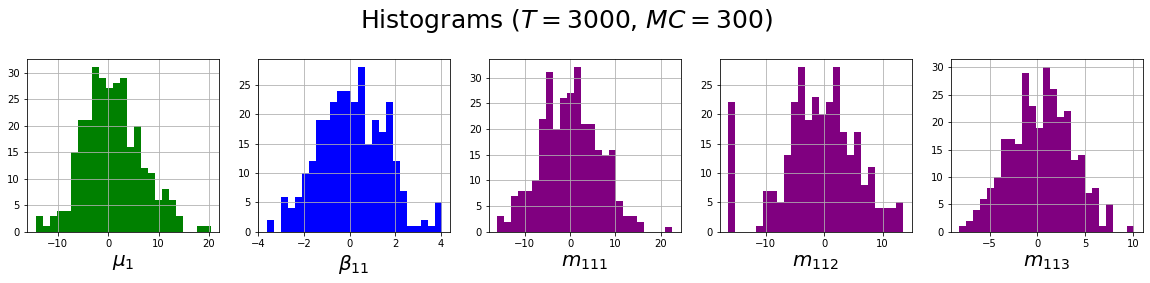

In [10]:
title = r'Histograms ($T=%d$, $MC=%d$)' %(t_max, MC)
SavePath = 'POE/add_ver3_POE_eg2_AN_T=%d_MC=%d.eps'  %(t_max, MC)
GEMHP_Hist(poeErrorList, dims, title, SavePath)

In [11]:
##　Generate Path of Intensity
def Intensity(arrivals, marks, delta, params, kernel = PolyExpKernel, g = gLinear):
    # Output : Res = np.array([[value of intensity, time, dim], ...])
    _params = params.copy()
    dim = len(_params[0])
    if _params[3].size == 0: _params[3] = np.concatenate([np.ones((dim, dim, 1)), np.zeros((dim, dim, 1))], axis=2)
    mu, alpha, beta, m, paramsMark, initEps = _params
    d_alpha, d_mark = len(alpha[0,0]), len(m[0,0])-1
    
    ## Initial Value
    intensity, Eps = Attenuator(0, initEps, _params, kernel)
    Res = np.concatenate([[intensity], [np.zeros(dim)], [range(1,dim+1)]]).T

    ## Values of Intensity
    for i in range(dim-1, len(arrivals)-(dim-1)-1): # 最初と最後は打点がdim個だけ被っているため，取り除いて考える
        t_seq = np.arange(arrivals[i][0], arrivals[i+1][0], delta) # intervalを間隔deltaで刻む
        for t in t_seq:
            intensity, Eps = Attenuator(delta, Eps, _params, kernel)
            Res = np.append(Res, np.array([intensity, np.repeat(t, dim), range(1,dim+1)]).T, axis=0)
        # seqで間引かれるため，最後の点は別途計算
        intensity, Eps = Attenuator(arrivals[i+1][0] - t_seq[-1], Eps, _params, kernel)
        Res = np.append(Res, np.array([intensity, np.repeat(arrivals[i+1][0], dim), range(1,dim+1)]).T, axis=0)
        # Jumpさせる
        if i < len(arrivals)-(dim-1)-2: # Marksのサイズはarrivalと異なることに注意
            intensity, Eps = Excitor(Eps, marks[i+1-dim, -1], marks[i+1-dim, :-1], _params, kernel, g)

    return Res
## Function for Plot
def GEMHP_Plot(arrivals, marks, delta, params, kernel = PolyExpKernel, g = gLinear, SavePath="", MarkPlot= True):
    # Simulation p.p.
    t_max = arrivals[-1][0]
    # Simulation intensity
    _Intensity = Intensity(arrivals, marks, delta, params, kernel, g)
    
    # plot用の画面分割
    dim = len(params[0])
    markDim = len(marks[0])-1
    if MarkPlot:
        fig = plt.figure(figsize=(15, 4*(2+markDim)/dim))
        gs = gridspec.GridSpec(4+markDim,dim)
    else:
        fig = plt.figure(figsize=(15, 8/dim))
        gs = gridspec.GridSpec(4,dim)
        
    plt.subplots_adjust(hspace=0,wspace=0.3)

    for i in range(dim):
        time = arrivals[arrivals.T[:][1]==i+1]
        time = time.T[:][0]
        N = np.append(np.array(range(len(time)-1)), len(time)-2)     
        ax = fig.add_subplot(gs[0:2,i])
        ax.set_xlim([-t_max*0.03, t_max*1.03])
        ax.plot(time, N,  color='red', drawstyle='steps-post')
        ax.set_ylabel("$N^{%d}$" %(i+1), fontsize=20)
        ax.grid()

        lambda_i = _Intensity[_Intensity.T[:][2]==i+1]
        time = lambda_i.T[:][1]
        lambda_i = lambda_i.T[:][0]
        ax = fig.add_subplot(gs[2:4,i])
        ax.set_xlim([-t_max*0.03, t_max*1.03])
        ax.set_ylim([0, max(lambda_i)*1.1])
        ax.plot(time, lambda_i,  color='blue')
        ax.axhline(params[0][i], ls = "-.", color = "magenta")
        ax.set_ylabel("$\lambda^{%d}$" %(i+1), fontsize=20)
        ax.grid()
        
        if MarkPlot:
            for j in range(markDim):
                time = arrivals.T[:][0][dim:-dim]
                ax = fig.add_subplot(gs[4+j,i])
                ax.set_xlim([-t_max*0.03, t_max*1.03])
                ax.set_ylim([0, 1.1])
                ax.bar(time, marks[:,j], width=t_max*0.002, color="green")
                ax.set_ylabel("Topic $%d$" %(j+1), fontsize=20)
                ax.grid()
            
        ax.set_xlabel("time", fontsize=20)

    fig.suptitle('GEMHP Simulation', fontsize=30)
    plt.show()
    if SavePath != "" : fig.savefig(SavePath)

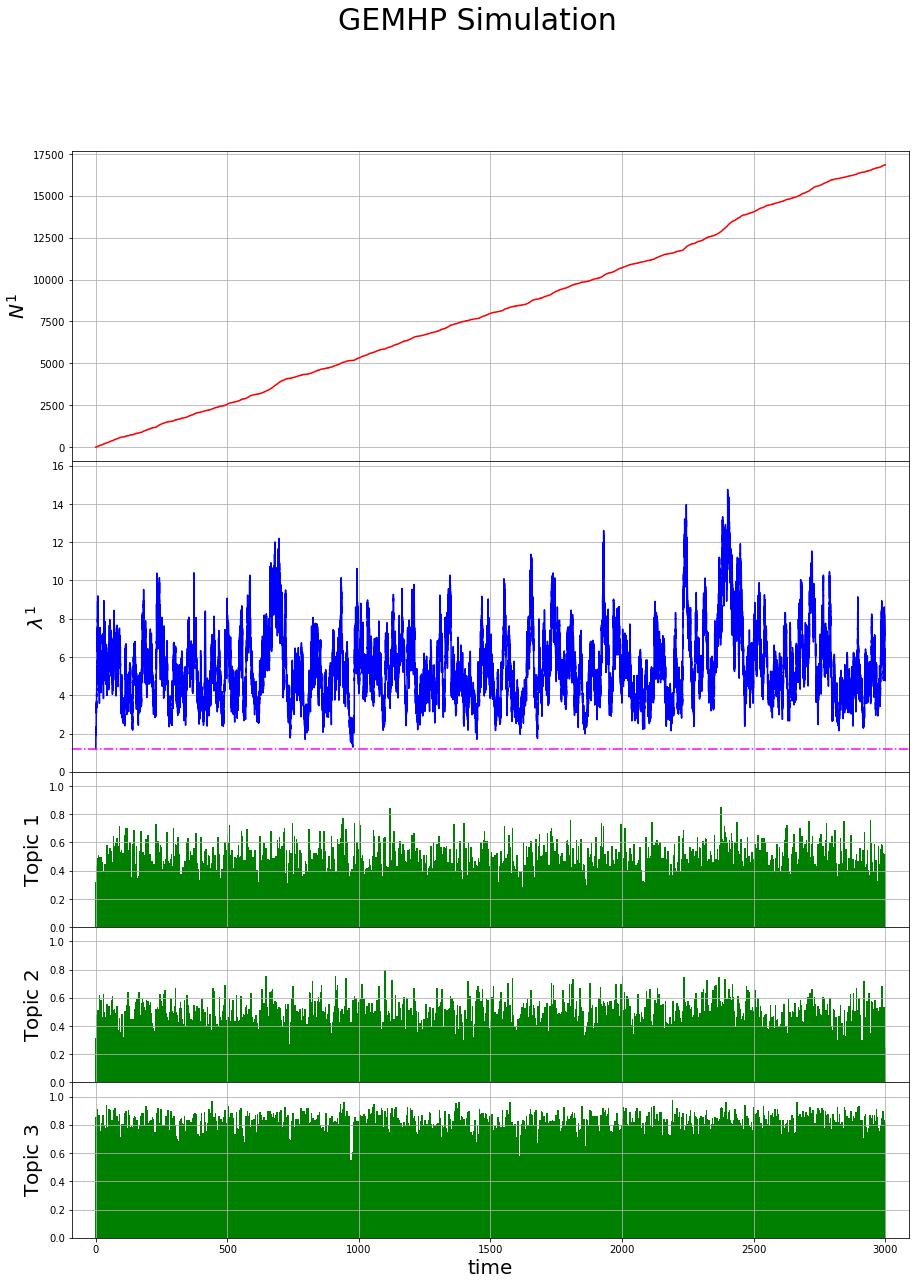

In [12]:
GEMHP_Plot(arrivals, marks, 0.01, params)